# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
# Installing opencv package for cv2 for resizing images
!pip install opencv-python-headless

In [2]:
# Importing necessary packages
import numpy as np
import os
# imread is deprecated in scipy now
# from scipy.misc import imread, imresize
import datetime
import os

# For reading images from file
import imageio
from imageio import imread
import cv2
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
# set_random_seed function is moved to random.set_seed
# tf.set_random_seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('/Users/bippu/Desktop/IMP/Upgrad Class/Deep Learning/Gesture Recognition_Case Study/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/Users/bippu/Desktop/IMP/Upgrad Class/Deep Learning/Gesture Recognition_Case Study/Project_data/val.csv').readlines())
batch_size = 100 #experiment with the batch size

In [5]:
# Number of train and validation videos
print('Number of train videos- ', len(train_doc))
print('Number of train videos- ', len(val_doc))


Number of train videos-  663
Number of train videos-  100


(360, 360, 3)


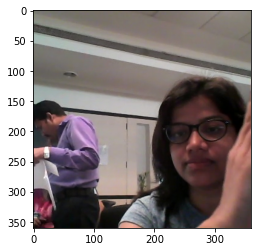

In [6]:
# Previewing one of the images
im = imread('/Users/bippu/Desktop/IMP/Upgrad Class/Deep Learning/Gesture Recognition_Case Study/Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png')
print(im.shape)
imgplot = plt.imshow(im)
plt.show()


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #create a list of image numbers you want to use for a particular video
    img_idx = [3,7,9,11,15,19,23,27,29]
    img_cnt = 9
    img_size = 50
      
    while True:
        t = np.random.permutation(folder_list)
        # calculate the number of batches
        num_batches = len(t)// batch_size
        print('Number of batches = ', num_batches)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,img_cnt,img_size,img_size,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[0] == image.shape[1] == 360:
                        image_rszd = cv2.resize(image, (img_size, img_size))
                    elif ((image.shape[0] ==  120) & (image.shape[1] == 160)):
                        image_crpd = image[:, 20:140]
                        image_rszd = cv2.resize(image_crpd, (img_size, img_size))
                    
                    #Normalising image channels
                    image_rszd = image_rszd/255
                    batch_data[folder,idx,:,:,0] = image_rszd[:, :, 0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_rszd[:, :, 1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_rszd[:, :, 2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        rem_batches = len(t)% batch_size
        batch_data = np.zeros((rem_batches,img_cnt,img_size,img_size,3)) 
        batch_labels = np.zeros((rem_batches,5)) 
        for folder in range(rem_batches): # iterate over the remaining batches
            imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)              
                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes
                if image.shape[0] == image.shape[1] == 360:
                    image_rszd = cv2.resize(image, (img_size, img_size))
                elif ((image.shape[0] ==  120) & (image.shape[1] == 160)):
                    image_crpd = image[:, 20:140]
                    image_rszd = cv2.resize(image_crpd, (img_size, img_size))
                    
                #Normalising image channels
                image_rszd = image_rszd/255
                batch_data[folder,idx,:,:,0] = image_rszd[:, :, 0] #normalise and feed in the image
                batch_data[folder,idx,:,:,1] = image_rszd[:, :, 1] #normalise and feed in the image
                batch_data[folder,idx,:,:,2] = image_rszd[:, :, 2] #normalise and feed in the image
                    
            batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = '/Users/bippu/Desktop/IMP/Upgrad Class/Deep Learning/Gesture Recognition_Case Study/Project_data/train'
val_path = '/Users/bippu/Desktop/IMP/Upgrad Class/Deep Learning/Gesture Recognition_Case Study/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
model = Sequential()
model.add(Conv3D(16, (2,2,2), 
                 activation='relu', 
                 input_shape=(9, 50, 50, 3)))
model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))

model.add(Conv3D(
            32, (3,3,3), activation='relu'
        ))
model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax')) 

2022-12-08 13:00:03.253146: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [10]:
optimiser = 'adam'#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 8, 49, 49, 16)     400       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 24, 24, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 22, 22, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 11, 11, 32)    0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 23232)             0         
                                                                 
 dense (Dense)               (None, 128)               2

We have around 2million parameters to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [11]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [12]:
# For saving the model after each epoch.
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [14]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /Users/bippu/Desktop/IMP/Upgrad Class/Deep Learning/Gesture Recognition_Case Study/Project_data/train ; batch size = 100
Number of batches =  6


/var/folders/qs/4n18nmmd267cmjx74_y1bq540000gn/T/ipykernel_26674/1481715320.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
7/7 [==============================] - ETA: 0s - loss: 4.8022 - categorical_accuracy: 0.2112Source path =  /Users/bippu/Desktop/IMP/Upgrad Class/Deep Learning/Gesture Recognition_Case Study/Project_data/val ; batch size = 100
Number of batches =  1

Epoch 1: saving model to model_init_2022-12-0813_00_03.238514/model-00001-4.80219-0.21116-1.69499-0.29000.h5
7/7 [==============================] - 34s 5s/step - loss: 4.8022 - categorical_accuracy: 0.2112 - val_loss: 1.6950 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 1.6132 - categorical_accuracy: 0.2474Number of batches =  1

Epoch 2: saving model to model_init_2022-12-0813_00_03.238514/model-00002-1.61320-0.24736-1.49738-0.27000.h5
7/7 [==============================] - 33s 5s/step - loss: 1.6132 - categorical_accuracy: 0.2474 - val_loss: 1.4974 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/20
7/7 [==============================] - ETA: 0s - loss: 

7/7 [==============================] - 33s 5s/step - loss: 0.0886 - categorical_accuracy: 0.9894 - val_loss: 1.0833 - val_categorical_accuracy: 0.7300 - lr: 0.0010
Epoch 17/20
7/7 [==============================] - ETA: 0s - loss: 0.0748 - categorical_accuracy: 0.9925Number of batches =  1

Epoch 17: saving model to model_init_2022-12-0813_00_03.238514/model-00017-0.07481-0.99246-1.07167-0.76000.h5
7/7 [==============================] - 32s 5s/step - loss: 0.0748 - categorical_accuracy: 0.9925 - val_loss: 1.0717 - val_categorical_accuracy: 0.7600 - lr: 0.0010
Epoch 18/20
7/7 [==============================] - ETA: 0s - loss: 0.0646 - categorical_accuracy: 0.9910Number of batches =  1

Epoch 18: saving model to model_init_2022-12-0813_00_03.238514/model-00018-0.06457-0.99095-1.03135-0.72000.h5
7/7 [==============================] - 32s 5s/step - loss: 0.0646 - categorical_accuracy: 0.9910 - val_loss: 1.0313 - val_categorical_accuracy: 0.7200 - lr: 0.0010
Epoch 19/20
7/7 [===============

The model weights at epoch # 13 will be our final model. It has validation accuracy of 77% which is good. </br>
Model: model-00013-0.18151-0.95324-0.96800-0.77000.h5

Refer write up attached for details of other models experimented.